Import libraries

In [0]:
#libraries to manipulate dataset
import pandas as pd 
import numpy as np 

# library to visualize the data
import matplotlib.pyplot as plt


#libraries for normalization and split data 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#libraries for model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

#libraries for evaluation th model

from sklearn.metrics import classification_report, confusion_matrix


import itertools


## Data pre-processing and  Visulationa dataframe

load product data

In [4]:
products = pd.read_csv("/content/drive/My Drive/project for colab/data/products.csv")
print("shape:", products.shape)
products.head()

FileNotFoundError: ignored

In [0]:
products.price.mean()

25.34484840530919

load sales data

In [0]:
sales = pd.read_csv('sales_stock.csv' ) 
print("shape:",sales.shape)
sales.head()

shape: (620515, 6)


,date_number,product_id,color_id,size_id,sales,stock
0,0,310130,78467031,7026791.0,1.0,93.0
1,0,310130,78467031,8015276.0,2.0,62.0
2,0,310130,78467031,452052101.0,1.0,18.0
3,0,310130,78467031,541898038.0,2.0,42.0
4,0,310130,78467031,558685710.0,3.0,113.0


create data frame for sales by day

In [0]:
sales_day=pd.DataFrame(sales.groupby(['date_number']).sum()['sales']).reset_index()
sales_day.head()

,date_number,sales
0,0,30609.0
1,1,29806.0
2,2,28408.0
3,3,30983.0
4,4,40190.0


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


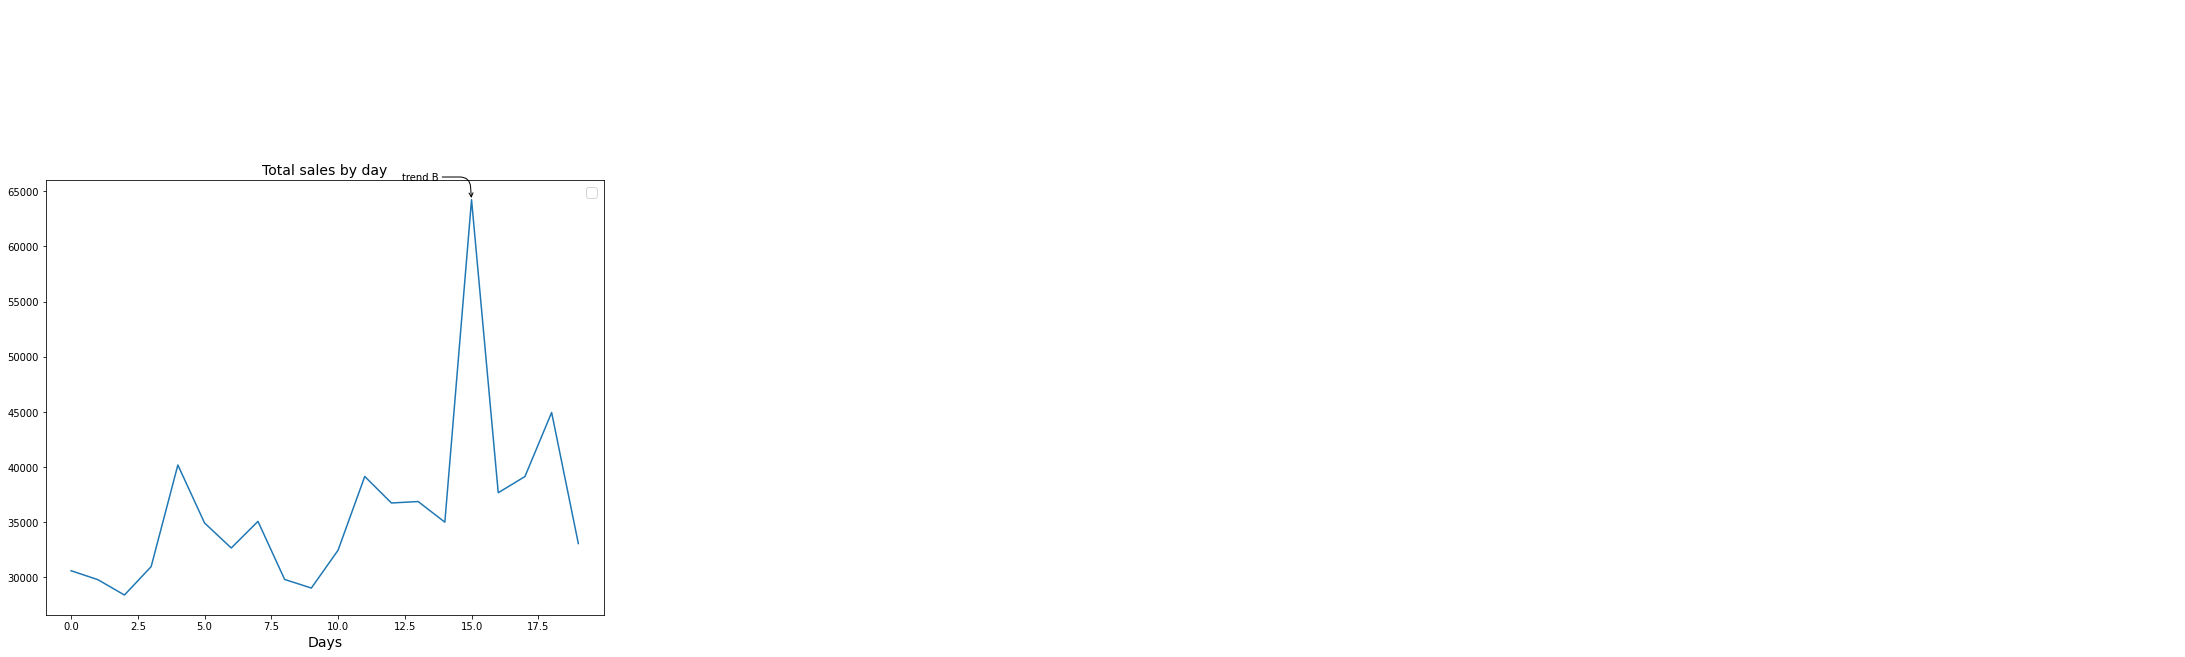

None

In [0]:
x = sales_day['date_number']
y = sales_day['sales']


plt.figure(figsize=(10,8))
plt.plot(x,y)
#plt.ylabel('Sales', fontsize=14)
plt.xlabel('Days',fontsize=14)
plt.title('Total sales by day',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
# Annotate arrow
plt.annotate('trend B',
            xy=(15,64200 ), xycoords='data',
            xytext=(-70, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc,angleA=0,armA=50,rad=10"))

plt.annotate('Cut off the data',
            xy=(71,36000 ), xycoords='data',
            xytext=(-80, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc,angleA=0,armA=80,rad=30"))

plt.annotate('trend A',
            xy=(79,81000 ), xycoords='data',
            xytext=(-80, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc,angleA=0,armA=50,rad=10"))
plt.annotate('trend C',
            xy=(32,48000 ), xycoords='data',
            xytext=(-70, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc,angleA=0,armA=50,rad=10"))

a=plt.show()
display(a)

since the goal is to predicte demand for next 3 weeks, the dataset split train(0-71) and test(72-91)

In [0]:
train_sales = sales.loc[sales['date_number'] <= 71].reset_index(drop=True)
test_sales = sales.loc[sales['date_number'] >= 72].reset_index(drop=True)

In [0]:
print(train_sales.shape)
train_sales.head()

(620515, 6)


,date_number,product_id,color_id,size_id,sales,stock
0,0,310130,78467031,7026791.0,1.0,93.0
1,0,310130,78467031,8015276.0,2.0,62.0
2,0,310130,78467031,452052101.0,1.0,18.0
3,0,310130,78467031,541898038.0,2.0,42.0
4,0,310130,78467031,558685710.0,3.0,113.0


In [0]:
print(test_sales.shape)
test_sales.head()

(0, 6)


,date_number,product_id,color_id,size_id,sales,stock


pre-process sales and products dataset to train the model

In [0]:
sales_df=pd.DataFrame(train_sales.groupby(['product_id']).sum()['sales']).reset_index()
sales_df.head()

,product_id,sales
0,213413,219.0
1,310130,272.0
2,571044,26.0
3,759150,9.0
4,1042445,5.0


Merge sales data with products to include the price and sales.

In [0]:
product_sales=pd.merge(products, train_sales, left_on='product_id', right_on='product_id')
product_sales.head()

,product_id,family_id,subfamily_id,price,date_number,color_id,size_id,sales,stock
0,213413,552529755,11509337,19.95,3,271590995,3000471.0,0.0,60.0
1,213413,552529755,11509337,19.95,3,271590995,319419383.0,1.0,18.0
2,213413,552529755,11509337,19.95,3,271590995,422108434.0,0.0,15.0
3,213413,552529755,11509337,19.95,3,271590995,558685710.0,0.0,25.0
4,213413,552529755,11509337,19.95,3,271590995,600575761.0,2.0,63.0


In [0]:
stay_columns=['product_id','price'] 

product_sales_final=pd.DataFrame(product_sales.groupby(stay_columns).sum()['sales']).reset_index()

product_sales_final.head()

,product_id,price,sales
0,213413,19.95,219.0
1,310130,12.95,272.0
2,571044,15.95,26.0
3,759150,17.95,9.0
4,1042445,49.99,5.0


Load positions data

In [0]:
positions = pd.read_csv('positions.csv')
print("shape:",positions.shape)
positions.head()

shape: (938011, 4)


,date_number,product_id,category_id,position
0,0,4450020,4461548,17.0
1,0,42147334,4461548,4.0
2,0,81131830,4461548,35.0
3,0,84035833,4461548,38.0
4,0,125252584,4461548,39.0


In [0]:
print('There are {} product_id in dataset.'.format(len(products['product_id'].unique())))
print('But there are only {} have positions.'.format(len(positions['product_id'].unique())))

There are 15238 product_id in dataset.
But there are only 8316 have positions.


In [0]:
print('There are {} product_id in dataset.'.format(len(products['product_id'].unique())))
print('But there are only {} have sales.'.format(len(sales['product_id'].unique())))

There are 15238 product_id in dataset.
But there are only 6153 have sales.


split positions data by day to traind the model

In [0]:
train_positions = positions.loc[positions['date_number'] <= 71].reset_index(drop=True)
test_positions = positions.loc[positions['date_number'] >= 72].reset_index(drop=True)

pre-process the positions

high_rank: minimum (best) position of each product

In [0]:
#insert column high_rank 
train_positions.loc[:,'high_rank']=train_positions.loc[:,'position'] 
# select the min value of position for each product in each day
high_rank=pd.DataFrame(train_positions.groupby(['product_id']).min()['position'] ).reset_index()
train_positions=train_positions.drop('high_rank', axis=1)

low_rank: maximum (worst) position of each product

In [0]:
# insert column low_rank 
train_positions.loc[:,'low_rank']=train_positions.loc[:,'position'] 
#select the max value of position for each product in each day
low_rank=pd.DataFrame(train_positions.groupby(['product_id']).max()['position'] ).reset_index()
train_positions=train_positions.drop('low_rank', axis=1)

calculate the mean position for every product

In [0]:
train_positions.loc[:,'rank_mean']=train_positions.loc[:,'position'] 
rank_mean=pd.DataFrame(train_positions.groupby(['product_id']).mean()['position']).reset_index()
rank_mean=round(rank_mean)
train_positions=train_positions.drop('rank_mean', axis=1)

creating final data fram for positions

In [0]:
positions_df=rank_mean.copy().rename(columns={"position": "rank_mean"}) 
positions_df.loc[:,'high_rank']=high_rank['position'] 
positions_df.loc[:,'low_rank']=low_rank['position'] 
print("shape:",positions_df.shape)
positions_df.head()

shape: (8316, 4)


,product_id,rank_mean,high_rank,low_rank
0,151926,39.0,9.0,65.0
1,213413,68.0,4.0,255.0
2,310130,23.0,2.0,80.0
3,455200,27.0,1.0,137.0
4,571044,77.0,5.0,202.0


creating final training data frame

In [0]:
df=pd.merge(product_sales_final, positions_df,  left_on=['product_id'], right_on=['product_id']) 
print(df.shape)
df.head()

(5800, 6)


,product_id,price,sales,rank_mean,high_rank,low_rank
0,213413,19.95,219.0,68.0,4.0,255.0
1,310130,12.95,272.0,23.0,2.0,80.0
2,571044,15.95,26.0,77.0,5.0,202.0
3,759150,17.95,9.0,47.0,1.0,282.0
4,1042445,49.99,5.0,130.0,52.0,178.0


In [0]:
df.corr()

,product_id,price,sales,rank_mean,high_rank,low_rank
product_id,1.000000,-0.002629,0.003806,0.014175,0.001129,0.022533
price,-0.002629,1.000000,-0.130212,-0.008172,0.039241,-0.008713
sales,0.003806,-0.130212,1.000000,-0.030217,-0.087628,0.015187
rank_mean,0.014175,-0.008172,-0.030217,1.000000,0.655403,0.888751
high_rank,0.001129,0.039241,-0.087628,0.655403,1.000000,0.352990
low_rank,0.022533,-0.008713,0.015187,0.888751,0.352990,1.000000


Sales by price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


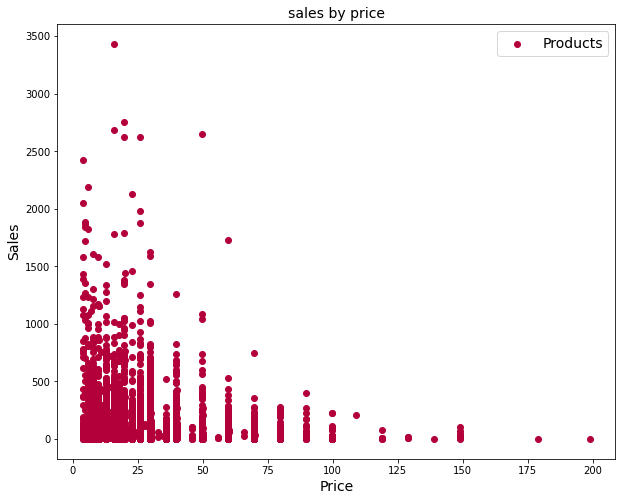

None

In [0]:
x = df['price']
y = df['sales']

plt.figure(figsize=(10,8))
plt.scatter(x,y,c='#b3003b',label='Products')
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Price',fontsize=14)
plt.title('sales by price',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
a=plt.show()
display(a)

Note: When the price is low, sales are high

Sales by mean product positions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


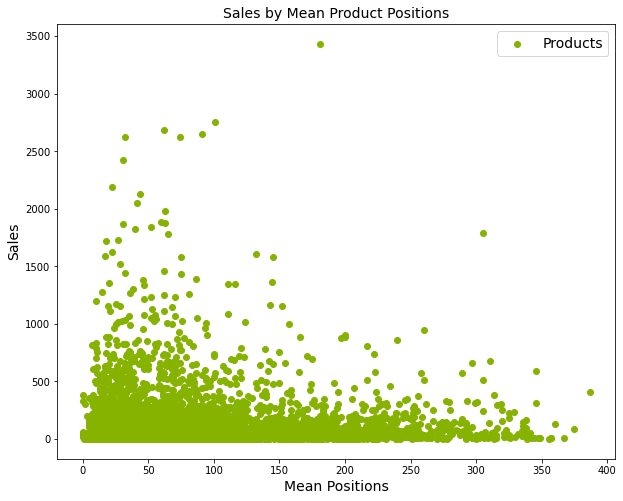

None

In [0]:
x = df['rank_mean']
y = df['sales']

plt.figure(figsize=(10,8))
plt.scatter(x,y,c='#86b300',label='Products')
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Mean Positions',fontsize=14)
plt.title('Sales by Mean Product Positions',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
a=plt.show()
display(a)

Note: When the mean is low( best), the sales are high

Sales by high rank

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


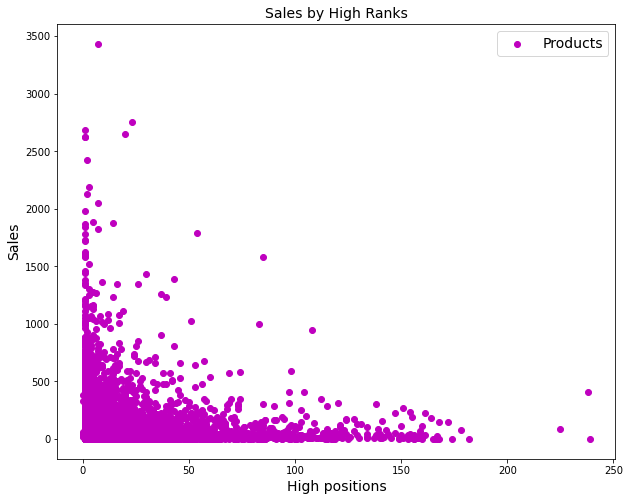

None

In [0]:
x = df['high_rank']
y = df['sales']

plt.figure(figsize=(10,8))
plt.scatter(x,y,c='m',label='Products')
plt.ylabel('Sales', fontsize=14)
plt.xlabel('High positions',fontsize=14)
plt.title('Sales by High Ranks',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
a=plt.show()
display(a)

Note: the sales are high when the product has high rank

Sales by low_rank

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


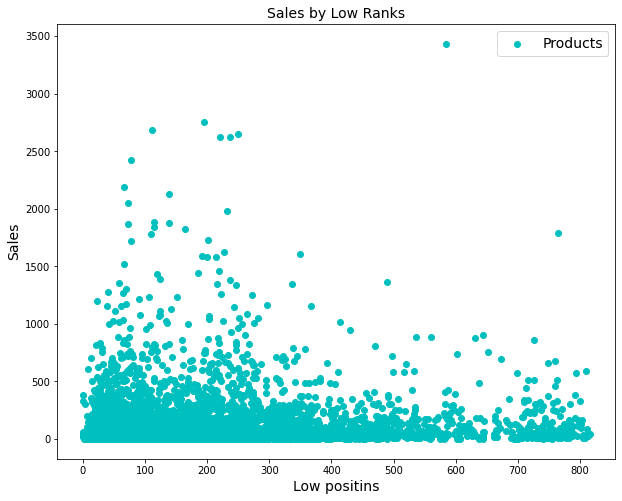

None

In [0]:
x = df['low_rank']
y = df['sales']

plt.figure(figsize=(10,8))
plt.scatter(x,y,c='c',label='Products')
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Low positins',fontsize=14)
plt.title('Sales by Low Ranks',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
a=plt.show()
display(a)

Note: sales are less when product rated by low

converted mean to two bins

In [0]:
bins=np.linspace(df.rank_mean.min(), df.rank_mean.max(), 5)

#customer reviews 10 to 1.
group_names=['4-stars','3-stars','2-stars','1-stars']

df['rank_level'] = pd.cut(df['rank_mean'],bins, labels=group_names,include_lowest=True)

df.head()

,product_id,price,sales,rank_mean,high_rank,low_rank,rank_level
0,213413,19.95,219.0,68.0,4.0,255.0,4-stars
1,310130,12.95,272.0,23.0,2.0,80.0,4-stars
2,571044,15.95,26.0,77.0,5.0,202.0,4-stars
3,759150,17.95,9.0,47.0,1.0,282.0,4-stars
4,1042445,49.99,5.0,130.0,52.0,178.0,3-stars


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


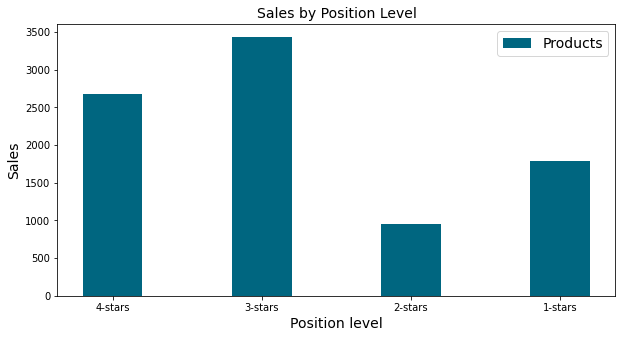

None

In [0]:
x = df['rank_level']
y = df['sales']

plt.figure(figsize=(10,5))
plt.bar(x,y,color='#006680',label='Products',width=0.4)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Position level',fontsize=14)
plt.title('Sales by Position Level',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
a=plt.show()
display(a)

Note: sales incresed by high rate

In [0]:
df['rank_level'] = pd.cut(df['rank_mean'],bins=2, labels=False)

df.rank_level.count()

5800

converted the mean to deal or denial for product status.

In [0]:
df['product_status'] = df['rank_level'].apply(lambda x: "denial" if (x>0)  else "deal")
df=df.drop(columns=('rank_level'))
df.head()

,product_id,price,sales,rank_mean,high_rank,low_rank,product_status
0,213413,19.95,219.0,68.0,4.0,255.0,deal
1,310130,12.95,272.0,23.0,2.0,80.0,deal
2,571044,15.95,26.0,77.0,5.0,202.0,deal
3,759150,17.95,9.0,47.0,1.0,282.0,deal
4,1042445,49.99,5.0,130.0,52.0,178.0,deal


visulaze the resutl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper lift'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


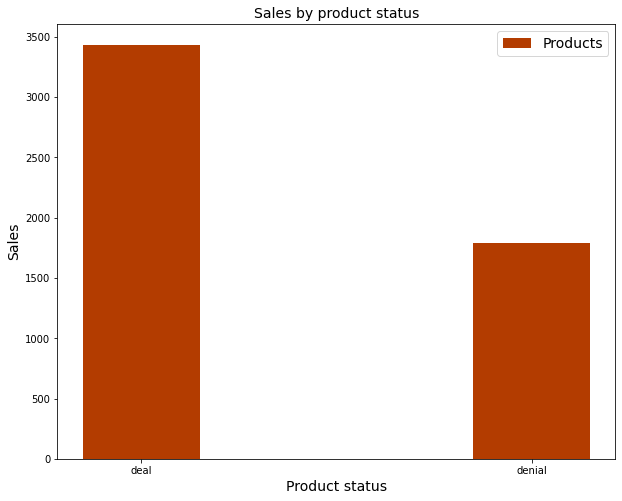

None

In [0]:
x = df['product_status']
y = df['sales']

plt.figure(figsize=(10,8))
plt.bar(x,y,color='#b33c00',label='Products',width=0.3)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Product status',fontsize=14)
plt.title('Sales by product status',fontsize=14)
plt.legend(loc='upper lift', fontsize=14)
a=plt.show()
display(a)

pre-processing testset

In [0]:
sales71=pd.DataFrame(test_sales.groupby(['product_id']).sum()['sales']).reset_index()

In [0]:
sales71=pd.merge(products, sales71, left_on='product_id', right_on='product_id')

In [0]:
stay_columns=['product_id','price'] 
sales71=pd.DataFrame(sales71.groupby(stay_columns).sum()['sales']).reset_index()

In [0]:
test_positions.loc[:,'high_rank']=test_positions.loc[:,'position'] 
high_rank=pd.DataFrame(test_positions.groupby(['product_id']).min()['position'] ).reset_index()
test_positions=test_positions.drop('high_rank', axis=1)

In [0]:
test_positions.loc[:,'low_rank']=test_positions.loc[:,'position'] 
low_rank=pd.DataFrame(test_positions.groupby(['product_id']).max()['position'] ).reset_index()
test_positions=test_positions.drop('low_rank', axis=1)

In [0]:
test_positions.loc[:,'rank_mean']=test_positions.loc[:,'position'] 
rank_mean=pd.DataFrame(test_positions.groupby(['product_id']).mean()['position']).reset_index()
rank_mean=round(rank_mean)
test_positions=test_positions.drop('rank_mean', axis=1)

In [0]:
positions_test=rank_mean.copy().rename(columns={"position": "rank_mean"}) 
positions_test.loc[:,'high_rank']=high_rank['position'] 
positions_test.loc[:,'low_rank']=low_rank['position'] 

In [0]:
test_df=pd.merge(sales71, positions_test,  left_on=['product_id'], right_on=['product_id']) 

In [0]:
test_df['rank_level'] = pd.cut(test_df['rank_mean'],bins=2, labels=False)

ValueError: ignored

In [0]:
test_df['product_status'] = test_df['rank_level'].apply(lambda x: "denial" if (x>0)  else "deal")
test_df=test_df.drop(columns=('rank_level'))

KeyError: ignored

### Selecting the feature

In [0]:
X_train = df[['price','sales','high_rank','low_rank']]

X_train[0:5]

In [0]:
y_train = df['product_status'].values
y_train[0:5]

In [0]:
X_test = test_df[['price','sales','high_rank','low_rank']]

X_test[0:5]

In [0]:
y_test = test_df['product_status'].values
y_test[0:5]

### Normalize Data

In [0]:
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

In [0]:
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

## Model

In [0]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

In [0]:
LR_yhat = LR_model.predict(X_test)

In [0]:
LR_yhat

In [0]:
a = np.count_nonzero(LR_yhat == 'deal')
print('Total number of deal product is ',a)
#print(b = np.count_nonzero(LR_yhat == 'denial'))

In [0]:
b = np.count_nonzero(LR_yhat == 'denial')
print('Total number of denial product is ',b)

## Model Evaluation

confusion_matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, LR_yhat, labels=['denial','deal']))

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR_yhat, labels=['denial','deal'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
a=plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['denial = 0','deal = 1'],normalize= True,  title='Confusion matrix')
display(a)